In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from mtcnn import MTCNN
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import shutil
from PIL import Image
import os
import numpy as np

# Caminhos
ROOT = ".."  # Pois o notebook está em notebooks/
PATH_ORIGINAIS = os.path.join(ROOT, "imagens_originais")
PATH_AUMENTADAS = os.path.join(ROOT, "imagens_aumentadas")
PATH_SEGMENTADAS = os.path.join(ROOT, "imagens_segmentadas")
PATH_RESULTADO = os.path.join(ROOT, "cartelas_resultado")

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import cv2
import os
from tqdm import tqdm

# Carregar o modelo BiSeNet
from torchvision.models.segmentation import deeplabv3_resnet50

# BiSeNet leve para parsing facial
class BiSeNet(torch.nn.Module):
    def __init__(self, n_classes=19):
        super(BiSeNet, self).__init__()
        self.model = deeplabv3_resnet50(pretrained=False, num_classes=n_classes)

    def forward(self, x):
        return self.model(x)['out']

# Carregar o modelo treinado
n_classes = 19
model = BiSeNet(n_classes=n_classes)
model.load_state_dict(torch.load("faceparsing_bisenet.pth", map_location='cpu'))
model.eval()

# Transformações para o modelo
to_tensor = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])


In [4]:
from PIL import Image

def aplicar_augmentacoes_basicas(imagem):
    augmentadas = []
    augmentadas.append(imagem.transpose(Image.FLIP_LEFT_RIGHT))  # flip horizontal
    augmentadas.append(imagem.rotate(90, expand=True))
    augmentadas.append(imagem.rotate(180, expand=True))
    augmentadas.append(imagem.rotate(270, expand=True))
    augmentadas.append(imagem.transpose(Image.FLIP_LEFT_RIGHT).rotate(90, expand=True))
    return augmentadas

# Gerar imagens aumentadas se ainda não existirem
os.makedirs(PATH_AUMENTADAS, exist_ok=True)
arquivos_existentes = set(os.listdir(PATH_AUMENTADAS))

print("🔄 Gerando imagens aumentadas (se necessário)...")
for filename in tqdm(sorted(os.listdir(PATH_ORIGINAIS))):
    base_name = os.path.splitext(filename)[0]
    needs_augmentation = any(
        f"{base_name}_aug{i}.jpg" not in arquivos_existentes for i in range(5)
    )

    if not needs_augmentation:
        continue  # já foi aumentado antes

    img_path = os.path.join(PATH_ORIGINAIS, filename)
    try:
        image = Image.open(img_path).convert("RGB")
    except:
        continue

    augmented_images = aplicar_augmentacoes_basicas(image)

    for i, aug_img in enumerate(augmented_images):
        aug_filename = f"{base_name}_aug{i}.jpg"
        aug_path = os.path.join(PATH_AUMENTADAS, aug_filename)
        aug_img.save(aug_path)


🔄 Gerando imagens aumentadas (se necessário)...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 460/460 [00:28<00:00, 16.00it/s]


In [5]:
import os
import cv2
import numpy as np

def carregar_imagens_segmentadas(pasta):
    imagens = []
    nomes = []
    for nome_arquivo in sorted(os.listdir(pasta)):
        caminho = os.path.join(pasta, nome_arquivo)
        img = cv2.imread(caminho)
        if img is not None:
            img = cv2.resize(img, (100, 100))  # padronizar tamanho
            imagens.append(img)
            nomes.append(nome_arquivo)
    return np.array(imagens), nomes

def extrair_features_tons(imagens):
    features = []
    for img in imagens:
        pixels = img.reshape(-1, 3)
        pixels = pixels[~np.all(pixels == [0, 0, 0], axis=1)]  # remover fundo preto
        if len(pixels) == 0:
            features.append([0]*6)
            continue
        media = np.mean(pixels, axis=0)
        std = np.std(pixels, axis=0)
        percentis = np.percentile(pixels, [25, 50, 75], axis=0).flatten()
        feat = np.concatenate([media, std, percentis])
        features.append(feat)
    return np.array(features)

    
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

def clusterizar_em_12_cartelas(features):
    pca = PCA(n_components=10)
    reduzido = pca.fit_transform(features)

    kmeans = KMeans(n_clusters=12, random_state=42)
    labels = kmeans.fit_predict(reduzido)
    return labels



In [8]:
# Processar todas as imagens em imagens_originais/
os.makedirs(PATH_SEGMENTADAS, exist_ok=True)
arquivos_segmentados = set(os.listdir(PATH_SEGMENTADAS))

print("🔄 Segmentando as imagens (se necessário)...")
for filename in tqdm(sorted(os.listdir(PATH_AUMENTADAS))):
    base_name = os.path.splitext(filename)[0]
    # Só segmenta se ainda não existir a versão segmentada
    if f"{base_name}.jpg" in arquivos_segmentados:
        continue

    img_path = os.path.join(PATH_AUMENTADAS, filename)
    output_path = os.path.join(PATH_SEGMENTADAS, filename)
    
    sucesso = segmentar_e_salvar(img_path, output_path)
    if not sucesso:
        print(f"Não foi possível detectar o rosto em: {filename}")


🔄 Segmentando as imagens (se necessário)...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1380/1380 [00:00<00:00, 639714.80it/s]


In [6]:
def get_color_hist_lab(image, bins=16):
    # Converter para LAB
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    # Separar canais
    l, a, b = cv2.split(lab)

    # Calcular histogramas normalizados
    hist_l = cv2.calcHist([l], [0], None, [bins], [0, 256]).flatten()
    hist_a = cv2.calcHist([a], [0], None, [bins], [0, 256]).flatten()
    hist_b = cv2.calcHist([b], [0], None, [bins], [0, 256]).flatten()

    hist_l /= hist_l.sum()
    hist_a /= hist_a.sum()
    hist_b /= hist_b.sum()

    return np.concatenate([hist_l, hist_a, hist_b])

from sklearn.cluster import KMeans

def get_dominant_color(image, k=3):
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pixels = img_rgb.reshape(-1, 3)
    
    # Remover pixels muito escuros ou claros
    pixels = pixels[(pixels > [30, 30, 30]).all(axis=1)]
    pixels = pixels[(pixels < [240, 240, 240]).all(axis=1)]

    if len(pixels) == 0:
        return [0, 0, 0]

    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pixels)
    counts = np.bincount(kmeans.labels_)
    dominant = kmeans.cluster_centers_[np.argmax(counts)]
    return dominant

def extrair_features_pele(image):
    hist_features = get_color_hist_lab(image, bins=8)       # 24 valores
    dominant_color = get_dominant_color(image, k=3)         # 3 valores
    return np.concatenate([hist_features, dominant_color])  # Total: 27


In [7]:
# Função para calcular a cor média da pele
def get_average_color(image):
    skin_pixels = image[np.where((image > [20, 20, 20]).all(axis=-1))]
    if len(skin_pixels) == 0:
        return [0, 0, 0]
    mean_color = np.mean(skin_pixels, axis=0)
    return mean_color

# Coletar cores médias de todas as imagens segmentadas
cores_peles = []
for filename in tqdm(os.listdir(PATH_SEGMENTADAS)):
    img_path = os.path.join(PATH_SEGMENTADAS, filename)
    img = cv2.imread(img_path)
    features = extrair_features_pele(img)  # Novo
    cores_peles.append(features)
    
# Normalizar as cores
cores_array = np.array(cores_peles)
cores_array = StandardScaler().fit_transform(cores_array)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1380/1380 [12:33<00:00,  1.83it/s]


In [14]:
from sklearn.preprocessing import StandardScaler

# Suponha que 'cores_peles' seja a lista com as cores médias
cores_array = np.array(cores_peles)

# Normalizar com StandardScaler
scaler = StandardScaler()
cores_array = scaler.fit_transform(cores_array)


/Users/laurinha/Documents/TCC3/versão atual/coloracao_pessoal_prototipo/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/laurinha/Documents/TCC3/versão atual/coloracao_pessoal_prototipo/venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Redução dimensional com UMAP concluída.


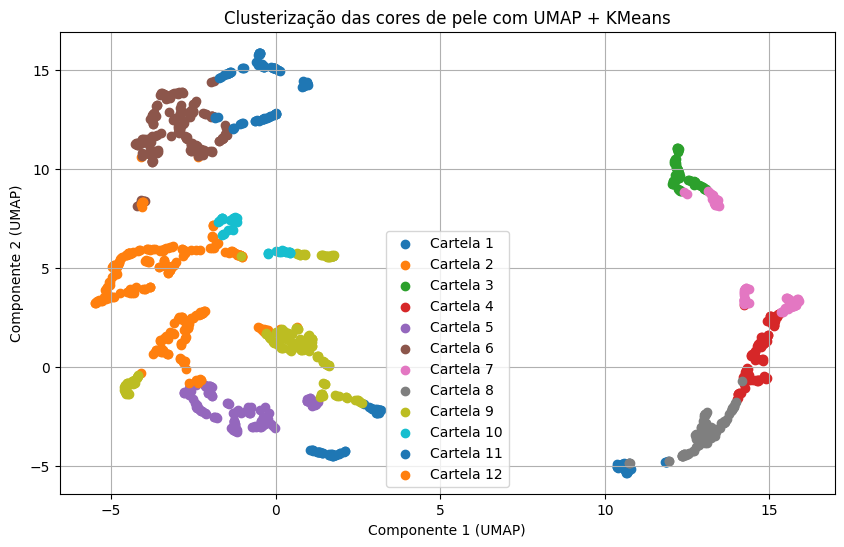

In [38]:
import umap

# UMAP para redução dimensional
umap_model = umap.UMAP(n_components=2, random_state=42)
cores_2d = umap_model.fit_transform(cores_array)

# Visualizar a variância explicada (opcional, UMAP não possui essa métrica direta como PCA)
print("Redução dimensional com UMAP concluída.")

# KMeans para clusterização em 12 cartelas
kmeans = KMeans(n_clusters=12, random_state=42)
labels = kmeans.fit_predict(cores_array)

# Visualização dos clusters
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i in range(12):
    plt.scatter(
        cores_2d[labels == i, 0],
        cores_2d[labels == i, 1],
        label=f"Cartela {i+1}"
    )
plt.legend()
plt.title("Clusterização das cores de pele com UMAP + KMeans")
plt.xlabel("Componente 1 (UMAP)")
plt.ylabel("Componente 2 (UMAP)")
plt.grid(True)
plt.show()


In [39]:
# Criar pasta para os resultados, se necessário
os.makedirs(PATH_RESULTADO, exist_ok=True)

# Criar subpastas para cada cartela
for i in range(12):
    os.makedirs(os.path.join(PATH_RESULTADO, f"cartela_{i+1}"), exist_ok=True)

# Associar as imagens segmentadas aos seus clusters e mover para as pastas apropriadas
segmentadas = sorted(os.listdir(PATH_SEGMENTADAS))

for i, filename in enumerate(segmentadas):
    src_path = os.path.join(PATH_SEGMENTADAS, filename)
    cluster = labels[i]  # de 0 a 11
    dst_path = os.path.join(PATH_RESULTADO, f"cartela_{cluster+1}", filename)
    shutil.copy(src_path, dst_path)


In [41]:
import os
import joblib

# Verificar e criar a pasta 'modelos_salvos' caso não exista
os.makedirs("modelos_salvos", exist_ok=True)

# Verificar se já existe o modelo de clusterização
if not os.path.exists("modelos_salvos/modelo_cluster.joblib"):
    # Se o modelo não existir, salva o novo modelo de clusterização
    joblib.dump(kmeans, "modelos_salvos/modelo_cluster.joblib")
else:
    print("Modelo de clusterização já existe, não foi salvo novamente.")

# Verificar se já existe o scaler
if not os.path.exists("modelos_salvos/scaler.joblib"):
    # Se o scaler não existir, salva o novo scaler
    joblib.dump(scaler, "modelos_salvos/scaler.joblib")
else:
    print("Scaler já existe, não foi salvo novamente.")

# Verificar se já existe o modelo UMAP
if not os.path.exists("modelos_salvos/reductor_umap.joblib"):
    # Se o modelo UMAP não existir, salva o novo modelo UMAP
    joblib.dump(umap_model, "modelos_salvos/reductor_umap.joblib")
else:
    print("Modelo UMAP já existe, não foi salvo novamente.")

print("Modelos salvos com sucesso.")


Modelo de clusterização já existe, não foi salvo novamente.
Scaler já existe, não foi salvo novamente.
Modelos salvos com sucesso.
